In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm

import seaborn as sns
from imblearn.over_sampling import SMOTE


import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier  # Example model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


In [2]:
 # Replace 'your_file.csv' with your filename
pd.set_option('display.max_columns', None)  # Show all columns
# print(df.head())  # Display the first few rows to check the data

def csv_cleaner(path, coi):
    df = pd.read_csv(path) 

    df = df[coi]
    print(len(df))

    # Count NaNs in each column
    nan_count = df.isnull().sum()

    # Display columns with NaNs
    print(nan_count[nan_count > 0])
    print(np.max(nan_count) / len(df))

    # drop the exceptional columns that still have NaNs
    NaNx_clean = df.dropna()
    print(len(NaNx_clean))

    return NaNx_clean

path_MDwarfs = 'gaia_matched/DESY_MDwarfs_Crossmatch.csv'
path_NotMDwarfs = 'gaia_matched/DESY_NotMDwarfs_Crossmatch.csv'
path_RData = 'gaia_matched/RANDOM_Stars_Crossmatch.csv'
#Only gaia data which are not strings nor predominantly NaNs
coi = ['ra_epoch2000','dec_epoch2000','errHalfMaj','errHalfMin','errPosAng',
    'astrometric_n_good_obs_al','astrometric_gof_al',
    'astrometric_chi2_al','astrometric_excess_noise','astrometric_excess_noise_sig',
    'astrometric_params_solved','visibility_periods_used','dr2_rv_nb_transits',
    'phot_g_mean_mag_error','phot_bp_mean_mag_error','phot_rp_mean_mag_error',
    'phot_g_mean_mag_corrected','phot_g_mean_mag_error_corrected','phot_g_mean_flux_corrected',
    'phot_bp_rp_excess_factor_corrected','ra_epoch2000_error','dec_epoch2000_error',
    'ra_dec_epoch2000_corr','angDist']


MDwarfs = csv_cleaner(path_MDwarfs, coi)
MDwarfs['SPEC'] = 'M'

NotMDwarfs = csv_cleaner(path_NotMDwarfs, coi)
NotMDwarfs['SPEC'] = 'B'

RData = csv_cleaner(path_RData, coi)
RData['SPEC'] = 'ND'
length = len(RData)


1169
phot_g_mean_mag_error                 32
phot_bp_mean_mag_error                59
phot_g_mean_mag_corrected             32
phot_g_mean_mag_error_corrected       32
phot_g_mean_flux_corrected            32
phot_bp_rp_excess_factor_corrected    59
dtype: int64
0.0504704875962361
1110
287
phot_g_mean_mag_error                  4
phot_bp_mean_mag_error                14
phot_g_mean_mag_corrected              4
phot_g_mean_mag_error_corrected        4
phot_g_mean_flux_corrected             4
phot_bp_rp_excess_factor_corrected    14
dtype: int64
0.04878048780487805
273
70902
phot_g_mean_mag_error                  168
phot_bp_mean_mag_error                5569
phot_rp_mean_mag_error                5149
phot_g_mean_mag_corrected              168
phot_g_mean_mag_error_corrected        168
phot_g_mean_flux_corrected             168
phot_bp_rp_excess_factor_corrected    5611
dtype: int64
0.07913740091957913
65291


In [6]:
all_dat = pd.concat([MDwarfs, NotMDwarfs, RData[:int(length/2)]], axis=0)

X = all_dat.drop(columns=['SPEC'])  # Features
y = all_dat['SPEC']  # Labels

print(y.value_counts())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

smote = SMOTE(sampling_strategy='auto', random_state=42)

# Fit and resample the training data
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
print(pd.Series(y_resampled).value_counts())
# print(all_dat['SPEC'])

SPEC
ND    32645
M      1110
B       273
Name: count, dtype: int64
SPEC
ND    26105
M     26105
B     26105
Name: count, dtype: int64


In [4]:

# KNN classifier
knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
knn.fit(X_resampled, y_resampled)

# Predictions
y_pred = knn.predict(X_test)
print(pd.Series(y_pred).value_counts())

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))


ND    6332
M      337
B      137
Name: count, dtype: int64
Accuracy: 0.9513664413752572
              precision    recall  f1-score   support

           B       0.14      0.37      0.20        52
           M       0.41      0.64      0.50       214
          ND       1.00      0.97      0.98      6540

    accuracy                           0.95      6806
   macro avg       0.52      0.66      0.56      6806
weighted avg       0.97      0.95      0.96      6806



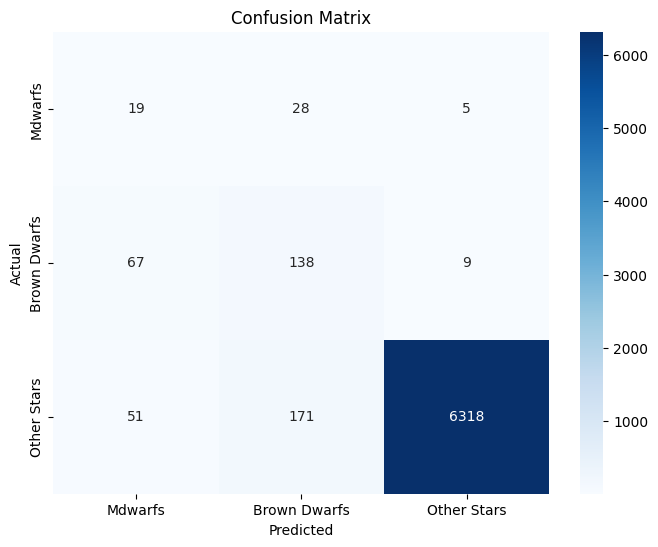

In [5]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Mdwarfs', 'Brown Dwarfs', 'Other Stars'], yticklabels=['Mdwarfs', 'Brown Dwarfs', 'Other Stars'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
